In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import numpy as np


In [2]:
transform_gray = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_rgb = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [3]:
datasets_dict = {
    "MNIST": datasets.MNIST(root="./data", train=True, download=True, transform=transform_gray),
    "FashionMNIST": datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform_gray),
    "CIFAR10": datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_rgb)
}

testsets_dict = {
    "MNIST": datasets.MNIST(root="./data", train=False, transform=transform_gray),
    "FashionMNIST": datasets.FashionMNIST(root="./data", train=False, transform=transform_gray),
    "CIFAR10": datasets.CIFAR10(root="./data", train=False, transform=transform_rgb)
}

batch_size = 64

dataloaders = {
    name: DataLoader(ds, batch_size=batch_size, shuffle=True)
    for name, ds in datasets_dict.items()
}
testloaders = {
    name: DataLoader(ds, batch_size=batch_size, shuffle=False)
    for name, ds in testsets_dict.items()
}


100%|██████████| 9.91M/9.91M [00:00<00:00, 33.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.32MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.30MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.32MB/s]
100%|██████████| 26.4M/26.4M [00:01<00:00, 16.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 267kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.1MB/s]
100%|██████████| 170M/170M [00:02<00:00, 60.9MB/s]


In [4]:
class LeNet5(nn.Module):
    def __init__(self, in_channels=1, num_classes=10): # Added in_channels and num_classes parameters
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5, stride=1) # Use in_channels here
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)        # S2
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)        # C3
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)        # S4
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)        # C5 (fully connected conv)
        self.fc1 = nn.Linear(120, 84)        # F6
        self.fc2 = nn.Linear(84, num_classes) # Use num_classes here

    def forward(self, x):
        x = torch.tanh(self.conv1(x))   # C1
        x = torch.tanh(self.pool1(x))   # S2
        x = torch.tanh(self.conv2(x))   # C3
        x = torch.tanh(self.pool2(x))   # S4
        x = torch.tanh(self.conv3(x))   # C5
        x = x.view(-1, 120)             # flatten
        x = torch.tanh(self.fc1(x))     # F6
        x = self.fc2(x)                 # Output
        return x

model = LeNet5()
print(model)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
def train_model(model, trainloader, testloader, device, epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.to(device)
    train_acc, test_acc = [], []
    train_loss, test_loss = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0) # Accumulate loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(trainloader.dataset) #  average training loss
        train_loss.append(epoch_train_loss)
        train_accuracy = 100 * correct / total
        train_acc.append(train_accuracy)

        model.eval()
        correct, total = 0, 0
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels) # Calculate test loss
                running_loss += loss.item() * images.size(0) # Accumulate test loss
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        epoch_test_loss = running_loss / len(testloader.dataset) # Calculate average test loss
        test_loss.append(epoch_test_loss)
        test_accuracy = 100 * correct / total
        test_acc.append(test_accuracy)


        print(f"Epoch [{epoch+1}/{epochs}] | Train Acc: {train_accuracy:.2f}% | Test Acc: {test_accuracy:.2f}% | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f}") # Added loss to print statement

    return train_acc, test_acc, train_loss, test_loss

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = {}
dataset_order = ["MNIST", "FashionMNIST", "CIFAR10"]
for name, trainloader in dataloaders.items():
    print(f"\nTraining on {name} dataset (Direct Training)...")
    in_channels = 3 if name == "CIFAR10" else 1
    num_classes = 10
    model = LeNet5(in_channels=in_channels, num_classes=num_classes)

    start_time = time.time()
    train_acc, test_acc, train_loss, test_loss = train_model(model, trainloader, testloaders[name], device)
    end_time = time.time()
    training_time = end_time - start_time

    results[name] = (train_acc, test_acc, train_loss, test_loss, training_time)
    print(f"Training time for {name} (Direct Training): {training_time:.2f} seconds")


# for name in dataset_order:
#     print(f"\nTraining on {name} dataset...")
#     in_channels = 3 if name == "CIFAR10" else 1
#     model = LeNet5(in_channels=in_channels, num_classes=10) # Instantiate a new model
#     trainloader = dataloaders[name]
#     testloader = testloaders[name]
#     train_acc, test_acc, train_loss, test_loss = train_model(model, trainloader, testloader, device)
#     sequential_results[name] = (train_acc, test_acc, train_loss, test_loss)


Training on MNIST dataset (Direct Training)...
Epoch [1/5] | Train Acc: 92.29% | Test Acc: 97.00% | Train Loss: 0.2666 | Test Loss: 0.1001
Epoch [2/5] | Train Acc: 97.52% | Test Acc: 98.05% | Train Loss: 0.0819 | Test Loss: 0.0632
Epoch [3/5] | Train Acc: 98.24% | Test Acc: 97.99% | Train Loss: 0.0563 | Test Loss: 0.0636
Epoch [4/5] | Train Acc: 98.61% | Test Acc: 98.34% | Train Loss: 0.0441 | Test Loss: 0.0510
Epoch [5/5] | Train Acc: 98.88% | Test Acc: 98.53% | Train Loss: 0.0350 | Test Loss: 0.0419
Training time for MNIST (Direct Training): 245.49 seconds

Training on FashionMNIST dataset (Direct Training)...
Epoch [1/5] | Train Acc: 78.49% | Test Acc: 83.23% | Train Loss: 0.5906 | Test Loss: 0.4623
Epoch [2/5] | Train Acc: 85.30% | Test Acc: 84.48% | Train Loss: 0.4013 | Test Loss: 0.4255
Epoch [3/5] | Train Acc: 86.86% | Test Acc: 85.82% | Train Loss: 0.3541 | Test Loss: 0.3772
Epoch [4/5] | Train Acc: 87.95% | Test Acc: 87.07% | Train Loss: 0.3238 | Test Loss: 0.3539
Epoch [5/5]

In [7]:
print(results)

results1 = {
    'MNIST': (
        [92.55166666666666, 97.54333333333334, 98.32333333333334, 98.62, 98.97333333333333, 99.06, 99.24166666666666, 99.32833333333333, 99.37, 99.455, 99.53833333333333, 99.54666666666667, 99.68166666666667, 99.58166666666666, 99.71333333333334, 99.69333333333333, 99.67, 99.75833333333334, 99.77666666666667, 99.78666666666666, 99.835, 99.70833333333333, 99.79166666666667, 99.86, 99.72166666666666, 99.8, 99.81166666666667, 99.85833333333333, 99.82166666666667, 99.745],
        [96.88, 97.81, 97.83, 98.47, 98.3, 98.52, 98.51, 98.57, 98.63, 98.41, 98.61, 98.57, 98.51, 98.62, 98.67, 98.79, 98.52, 98.65, 98.42, 98.43, 98.73, 98.52, 98.51, 98.6, 98.6, 98.62, 98.4, 98.59, 98.47, 98.43],
        [0.260493694070975, 0.0819983215165635, 0.055739262448002896, 0.043869023313745856, 0.0337399455246826, 0.030006300828543803, 0.02452922380116458, 0.02072699834283752, 0.019325843691662885, 0.01618859672934438, 0.013760307580108443, 0.013365845371014439, 0.010016218397952616, 0.012464130821373934, 0.008980858642491513, 0.0086399648900105, 0.010381002802708341, 0.007695206257995839, 0.0070966858326088796, 0.007296677381095166, 0.00524145934000262, 0.008330216541994014, 0.005883964284133981, 0.00479773366740216, 0.00741548088156948, 0.0061820867009519135, 0.005787698804336833, 0.004434224856599273, 0.0060282128947825794, 0.007661573905434731],
        [0.10519286830723286, 0.0729845001656562, 0.06317020355835556, 0.04851505772694945, 0.056526944981701674, 0.05255388269769028, 0.04853309191019507, 0.043602817882562525, 0.04357451960875187, 0.054721468892897245, 0.04703601197877433, 0.05025437920330005, 0.04974532017192687, 0.04779836755279975, 0.047892252481495964, 0.045588394416851225, 0.05641110555112828, 0.05292462219316512, 0.058492449477146144, 0.06230531043878873, 0.0544638583493419, 0.05839251364059601, 0.06196561618009873, 0.054986421321354284, 0.06516387875358032, 0.058928468959755266, 0.07081831927758904, 0.06577702587122149, 0.06696079258883837, 0.06926078247803089],
        1127.512199640274
    ),

    'FashionMNIST': (
        [78.02166666666666, 85.265, 87.185, 88.18, 88.87166666666667, 89.55, 90.13166666666666, 90.665, 90.97166666666666, 91.48, 91.88166666666666, 92.275, 92.51833333333333, 92.975, 93.32833333333333, 93.63, 93.90666666666667, 94.27, 94.40666666666667, 94.76833333333333, 94.94166666666666, 95.25166666666667, 95.49, 95.72833333333334, 95.94333333333333, 96.105, 96.33833333333334, 96.49833333333333, 96.78166666666667, 96.86333333333333],
        [82.93, 85.87, 86.47, 87.33, 86.75, 87.6, 87.55, 88.56, 89.09, 88.02, 89.08, 89.02, 89.0, 88.51, 88.78, 88.85, 88.95, 89.04, 89.04, 89.07, 88.93, 88.58, 88.49, 88.72, 88.35, 89.09, 88.57, 88.63, 88.93, 88.38],
        [0.598971447690328, 0.40125199467341105, 0.3512126195430756, 0.3226184993426005, 0.30216947260697685, 0.2829346429665883, 0.2682258488814036, 0.2534914588888486, 0.24182923653125762, 0.23098831431865693, 0.2188193405032158, 0.20931757811903953, 0.19975471933285396, 0.19016036425828933, 0.18052405190865198, 0.1752511234084765, 0.1664645891527335, 0.15715465469757717, 0.15122810991207758, 0.14308838915228844, 0.13840565042297046, 0.1301855057835579, 0.1236929356555144, 0.11899447642564774, 0.11256964338322481, 0.10636916241546472, 0.10160630976061026, 0.09676804343958696, 0.09053318027257919, 0.08761736391782761],
        [0.46702251522541044, 0.39236136932373045, 0.3718346965551376, 0.35647069779634477, 0.35804075548648834, 0.3423609632730484, 0.33198494913578036, 0.3179911935091019, 0.3067593390226364, 0.32825543620586395, 0.3112306872844696, 0.31221599813699724, 0.3124651114702225, 0.33198815703392026, 0.3338974451065064, 0.32404261479377744, 0.3399219528913498, 0.33228646862506866, 0.331249268078804, 0.3393152828574181, 0.35089594810009, 0.35940914120674133, 0.3673402683198452, 0.3633318095207214, 0.3766562388300896, 0.3776355487346649, 0.3981921880722046, 0.40890536441802977, 0.4140403918504715, 0.4302344352245331],
        1115.9085054397583
    ),

    'CIFAR10': (
        [37.11, 47.508, 52.068, 54.808, 57.388, 59.016, 60.426, 61.624, 62.868, 64.046, 64.982, 66.154, 67.018, 67.762, 68.594, 69.402, 70.218, 71.094, 71.926, 72.44, 73.138, 73.956, 74.454, 75.03, 75.752, 76.24, 77.254, 77.554, 77.97, 78.742],
        [44.25, 49.73, 51.83, 53.3, 54.85, 56.1, 56.36, 56.9, 57.17, 56.67, 57.47, 57.21, 57.55, 57.36, 57.25, 57.42, 57.34, 57.15, 57.5, 57.01, 56.69, 56.76, 56.63, 56.76, 56.35, 56.11, 56.55, 56.17, 56.05, 56.79],
        [1.7534923360824586, 1.4606671699905396, 1.3295099961090089, 1.2573598631286622, 1.2009969992828369, 1.1511287114334106, 1.111635012702942, 1.0766283687973022, 1.0444296572113037, 1.0134482667922973, 0.9863703443145752, 0.9566533863830566, 0.9294359697723389, 0.9068605179595948, 0.8838660304260254, 0.8611960160446167, 0.8389173856735229, 0.8189704371070862, 0.7949348483467102, 0.77900113489151, 0.7594368476104736, 0.7383135641860962, 0.7219730699539184, 0.7030240920448303, 0.6872241236877441, 0.6711954064369202, 0.6485468752670288, 0.635075369644165, 0.6221415933227539, 0.6050964234828949],
        [1.5505790954589844, 1.3923346462249755, 1.3421355590820312, 1.2946521482467652, 1.2638328372955323, 1.237080096054077, 1.2343147598266602, 1.2165396068572998, 1.2126416449546813, 1.233538541507721, 1.2289793472290038, 1.2362456354141236, 1.2314636520385742, 1.2480442588806153, 1.2611563751220702, 1.2752115368843078, 1.2866019580841064, 1.2923191205978393, 1.3270885555267333, 1.3404906917572021, 1.3491552923202514, 1.3718671754837035, 1.3767336240768433, 1.4146844617843628, 1.4389072149276734, 1.456387453842163, 1.4715284526824952, 1.5033440826416016, 1.51846311378479, 1.5256363006591798],
        934.8403494358063
    )
}


{'MNIST': ([92.29333333333334, 97.52166666666666, 98.23833333333333, 98.61333333333333, 98.88166666666666], [97.0, 98.05, 97.99, 98.34, 98.53], [0.2666013059238593, 0.0818870108311375, 0.05632824606808523, 0.044111125417488316, 0.03502665780497094], [0.10012055558860301, 0.06316293340884149, 0.06360334678515792, 0.050985649800486865, 0.04189845659956336], 245.48659324645996), 'FashionMNIST': ([78.48833333333333, 85.29833333333333, 86.865, 87.95, 88.825], [83.23, 84.48, 85.82, 87.07, 87.79], [0.5905633316675822, 0.40129712465604145, 0.35408236660162606, 0.3238162598133087, 0.302183011786143], [0.46225518119335174, 0.42549720108509065, 0.37723715567588806, 0.3539009174108505, 0.33853473961353303], 211.25710201263428), 'CIFAR10': ([37.198, 46.736, 51.29, 54.212, 56.614], [44.57, 49.27, 52.88, 53.89, 54.28], [1.7576265423583985, 1.4861764540481568, 1.3570819889831542, 1.277875246925354, 1.2222412120437622], [1.5692332969665528, 1.41391821308136, 1.3295764400482177, 1.2869329437255859, 1.27

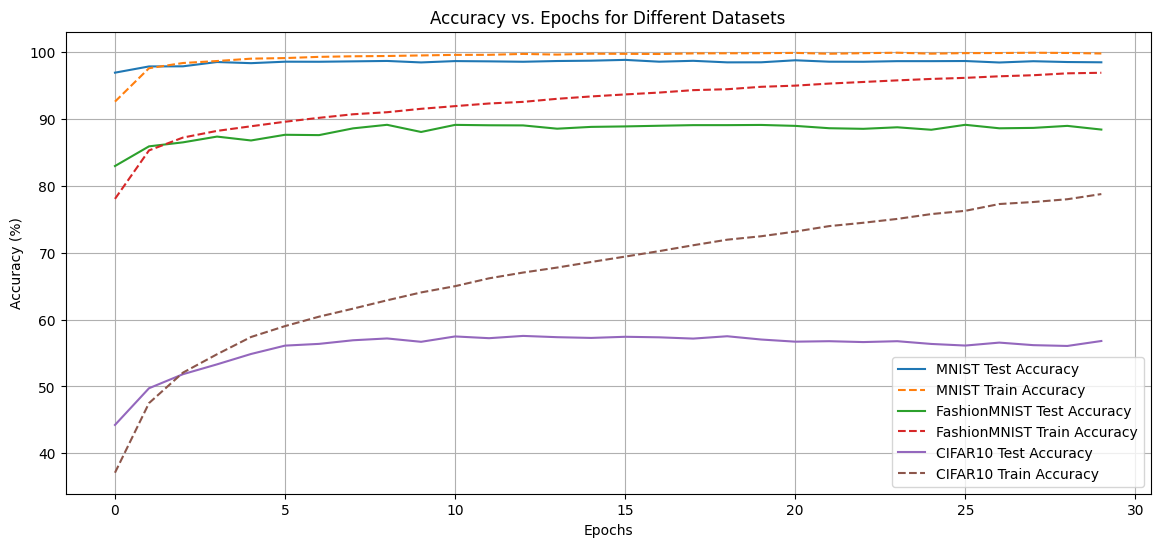

In [8]:
# plt.figure(figsize=(14, 6))
# for name, (train_acc, test_acc, _, _, _) in results.items():
#     plt.plot(test_acc, label=f'{name} Test Accuracy')
#     plt.plot(train_acc, label=f'{name} Train Accuracy', linestyle='--')
# plt.title("Accuracy vs. Epochs for Different Datasets")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy (%)")
# plt.legend()
# plt.grid(True)
# plt.show()
plt.figure(figsize=(14, 6))
for name, (train_acc, test_acc, _, _, _) in results1.items():
    plt.plot(test_acc, label=f'{name} Test Accuracy')
    plt.plot(train_acc, label=f'{name} Train Accuracy', linestyle='--')
plt.title("Accuracy vs. Epochs for Different Datasets")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


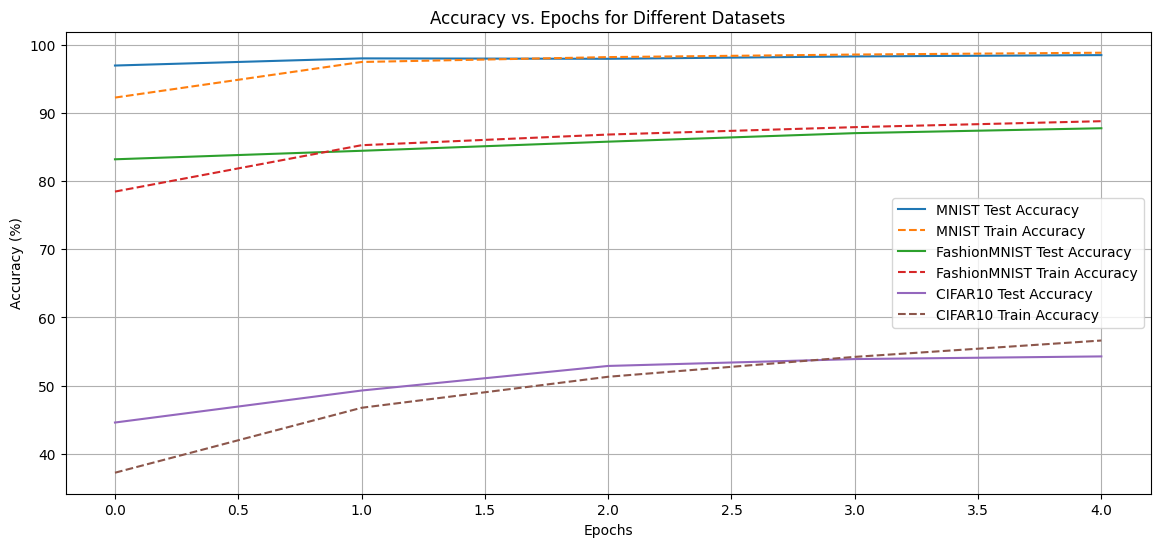

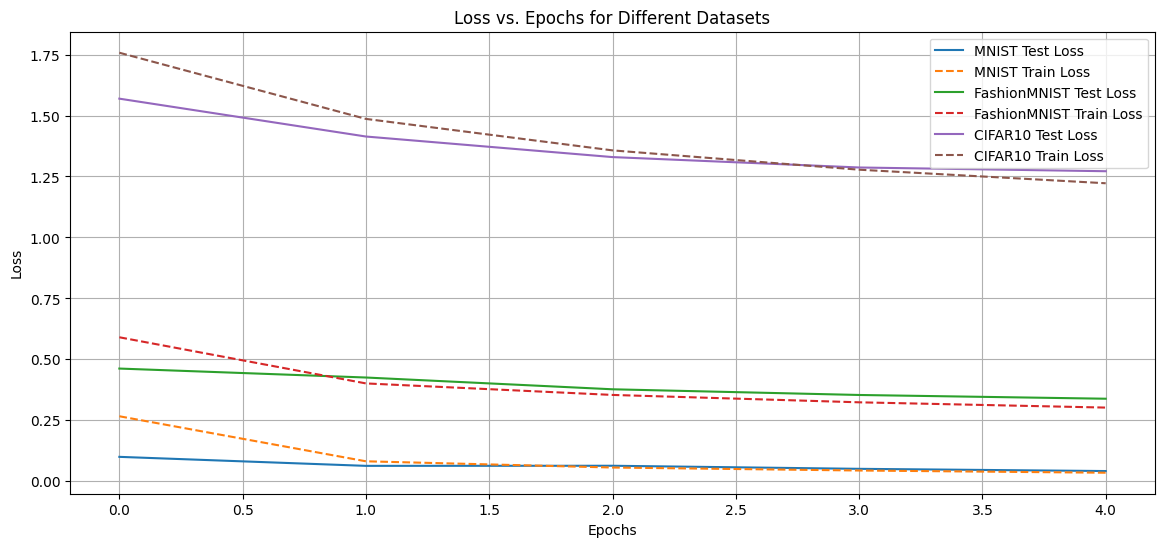

In [9]:
plt.figure(figsize=(14, 6))
for name, (train_acc, test_acc, _, _, _) in results.items():
    plt.plot(test_acc, label=f'{name} Test Accuracy')
    plt.plot(train_acc, label=f'{name} Train Accuracy', linestyle='--')
plt.title("Accuracy vs. Epochs for Different Datasets")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(14, 6))
for name, (_, _, train_loss, test_loss, _) in results.items():
    plt.plot(test_loss, label=f'{name} Test Loss')
    plt.plot(train_loss, label=f'{name} Train Loss', linestyle='--')
plt.title("Loss vs. Epochs for Different Datasets")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
for name, (train_acc, test_acc, train_loss, test_loss, training_time) in results.items():
    print(f"--- Results for {name} ---")
    print(f"Final Training Accuracy: {train_acc[-1]:.2f}%")
    print(f"Final Testing Accuracy: {test_acc[-1]:.2f}%")
    print(f"Final Training Loss: {train_loss[-1]:.4f}")
    print(f"Final Testing Loss: {test_loss[-1]:.4f}")
    print(f"Total Training Time: {training_time:.2f} seconds")
    print("-" * (len(f"--- Results for {name} ---")))

--- Results for MNIST ---
Final Training Accuracy: 98.88%
Final Testing Accuracy: 98.53%
Final Training Loss: 0.0350
Final Testing Loss: 0.0419
Total Training Time: 245.49 seconds
-------------------------
--- Results for FashionMNIST ---
Final Training Accuracy: 88.83%
Final Testing Accuracy: 87.79%
Final Training Loss: 0.3022
Final Testing Loss: 0.3385
Total Training Time: 211.26 seconds
--------------------------------
--- Results for CIFAR10 ---
Final Training Accuracy: 56.61%
Final Testing Accuracy: 54.28%
Final Training Loss: 1.2222
Final Testing Loss: 1.2716
Total Training Time: 179.68 seconds
---------------------------


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
curriculum_results = {}
previous_model = None

dataset_order = ["MNIST", "FashionMNIST", "CIFAR10"]

for i, name in enumerate(dataset_order):
    print(f"\nTraining on {name} dataset (Curriculum Training)...")
    in_channels = 3 if name == "CIFAR10" else 1
    model = LeNet5(in_channels=in_channels, num_classes=10)

    if previous_model is not None:
        # Adjust the state_dict to match the current model's layers,
        # especially for the first convolutional layer when changing channels
        state_dict = previous_model.state_dict()
        if name == "CIFAR10":
            new_state_dict = model.state_dict()
            for key in state_dict:
                if key in new_state_dict and state_dict[key].shape == new_state_dict[key].shape:
                    new_state_dict[key] = state_dict[key]
            model.load_state_dict(new_state_dict)
        else:
            model.load_state_dict(state_dict)

    trainloader = dataloaders[name]
    testloader = testloaders[name]

    start_time = time.time()
    train_acc, test_acc, train_loss, test_loss = train_model(model, trainloader, testloader, device)
    end_time = time.time()
    training_time = end_time - start_time

    curriculum_results[name] = (train_acc, test_acc, train_loss, test_loss, training_time)
    print(f"Training time for {name} (Curriculum Training): {training_time:.2f} seconds")
    previous_model = model # Store the trained model for the next iteration


Training on MNIST dataset (Curriculum Training)...
Epoch [1/5] | Train Acc: 92.34% | Test Acc: 97.23% | Train Loss: 0.2660 | Test Loss: 0.0931
Epoch [2/5] | Train Acc: 97.44% | Test Acc: 97.72% | Train Loss: 0.0827 | Test Loss: 0.0760
Epoch [3/5] | Train Acc: 98.27% | Test Acc: 98.09% | Train Loss: 0.0577 | Test Loss: 0.0614
Epoch [4/5] | Train Acc: 98.57% | Test Acc: 98.35% | Train Loss: 0.0453 | Test Loss: 0.0497
Epoch [5/5] | Train Acc: 98.88% | Test Acc: 98.57% | Train Loss: 0.0365 | Test Loss: 0.0475
Training time for MNIST (Curriculum Training): 215.45 seconds

Training on FashionMNIST dataset (Curriculum Training)...
Epoch [1/5] | Train Acc: 79.04% | Test Acc: 83.62% | Train Loss: 0.6289 | Test Loss: 0.4521
Epoch [2/5] | Train Acc: 85.73% | Test Acc: 86.17% | Train Loss: 0.3854 | Test Loss: 0.3825
Epoch [3/5] | Train Acc: 87.48% | Test Acc: 86.89% | Train Loss: 0.3391 | Test Loss: 0.3679
Epoch [4/5] | Train Acc: 88.52% | Test Acc: 88.05% | Train Loss: 0.3095 | Test Loss: 0.3368

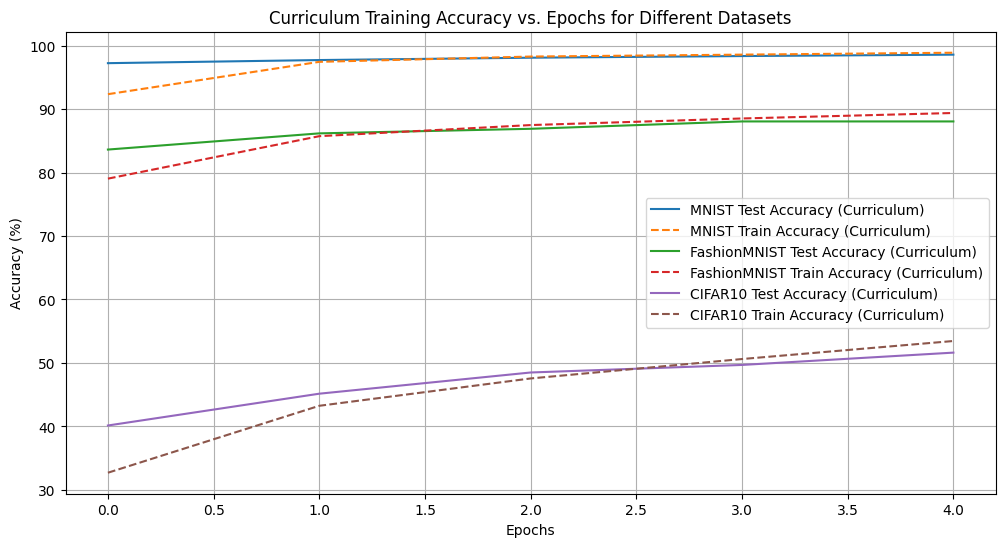

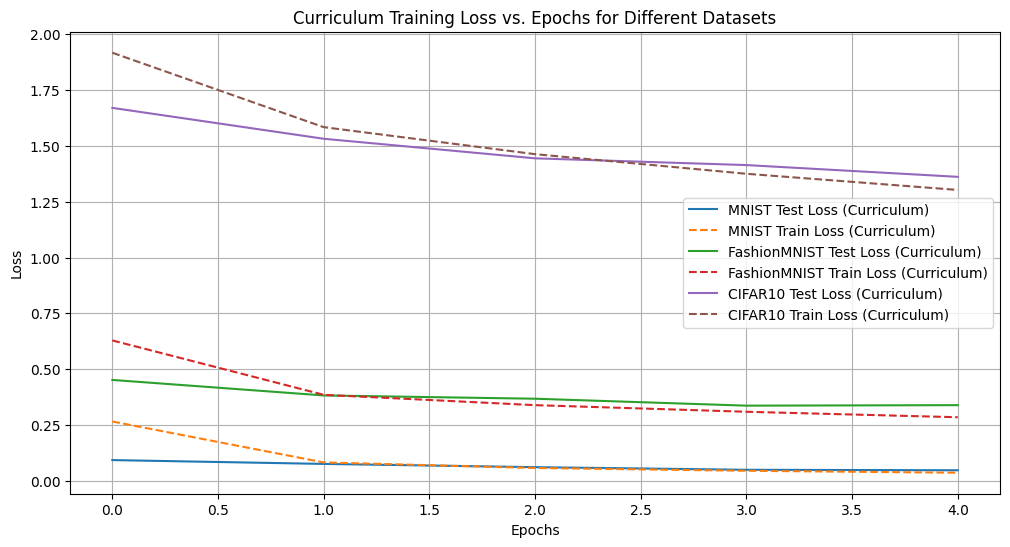

In [13]:
plt.figure(figsize=(12, 6))
for name, (train_acc, test_acc, _, _, _) in curriculum_results.items():
    plt.plot(test_acc, label=f'{name} Test Accuracy (Curriculum)')
    plt.plot(train_acc, label=f'{name} Train Accuracy (Curriculum)', linestyle='--')
plt.title("Curriculum Training Accuracy vs. Epochs for Different Datasets")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for name, (_, _, train_loss, test_loss, _) in curriculum_results.items():
    plt.plot(test_loss, label=f'{name} Test Loss (Curriculum)')
    plt.plot(train_loss, label=f'{name} Train Loss (Curriculum)', linestyle='--')
plt.title("Curriculum Training Loss vs. Epochs for Different Datasets")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
print("\n\n==================== SUMMARY ====================")
for name in dataset_order:
    print(f"\n📘 {name} RESULTS:")
    if name in results:
        # Access the last element of the test accuracy list and the training time
        print(f"Direct Training     → Test Acc: {results[name][1][-1]:.2f}% | Time: {results[name][4]:.2f}s")
    if name in curriculum_results:
        # Access the last element of the test accuracy list and the training time
        print(f"Curriculum Training → Test Acc: {curriculum_results[name][1][-1]:.2f}% | Time: {curriculum_results[name][4]:.2f}s")
print("=================================================\n")



==================== SUMMARY ====================

📘 MNIST RESULTS:
Direct Training     → Test Acc: 98.53% | Time: 245.49s
Curriculum Training → Test Acc: 98.57% | Time: 215.45s

📘 FashionMNIST RESULTS:
Direct Training     → Test Acc: 87.79% | Time: 211.26s
Curriculum Training → Test Acc: 88.05% | Time: 234.69s

📘 CIFAR10 RESULTS:
Direct Training     → Test Acc: 54.28% | Time: 179.68s
Curriculum Training → Test Acc: 51.63% | Time: 183.47s



In [18]:
print(results)
print(curriculum_results)

{'MNIST': ([92.29333333333334, 97.52166666666666, 98.23833333333333, 98.61333333333333, 98.88166666666666], [97.0, 98.05, 97.99, 98.34, 98.53], [0.2666013059238593, 0.0818870108311375, 0.05632824606808523, 0.044111125417488316, 0.03502665780497094], [0.10012055558860301, 0.06316293340884149, 0.06360334678515792, 0.050985649800486865, 0.04189845659956336], 245.48659324645996), 'FashionMNIST': ([78.48833333333333, 85.29833333333333, 86.865, 87.95, 88.825], [83.23, 84.48, 85.82, 87.07, 87.79], [0.5905633316675822, 0.40129712465604145, 0.35408236660162606, 0.3238162598133087, 0.302183011786143], [0.46225518119335174, 0.42549720108509065, 0.37723715567588806, 0.3539009174108505, 0.33853473961353303], 211.25710201263428), 'CIFAR10': ([37.198, 46.736, 51.29, 54.212, 56.614], [44.57, 49.27, 52.88, 53.89, 54.28], [1.7576265423583985, 1.4861764540481568, 1.3570819889831542, 1.277875246925354, 1.2222412120437622], [1.5692332969665528, 1.41391821308136, 1.3295764400482177, 1.2869329437255859, 1.27

--- Comparison of Training Approaches on CIFAR10 ---

Direct Training on CIFAR10:
  Final Testing Accuracy: 54.28%
  Final Testing Loss: 1.2716
  Total Training Time: 179.68 seconds

Curriculum Training (MNIST -> FashionMNIST -> CIFAR10):
  Final Testing Accuracy: 51.63%
  Final Testing Loss: 1.3614
  Total Training Time: 183.47 seconds
--------------------------------------------------


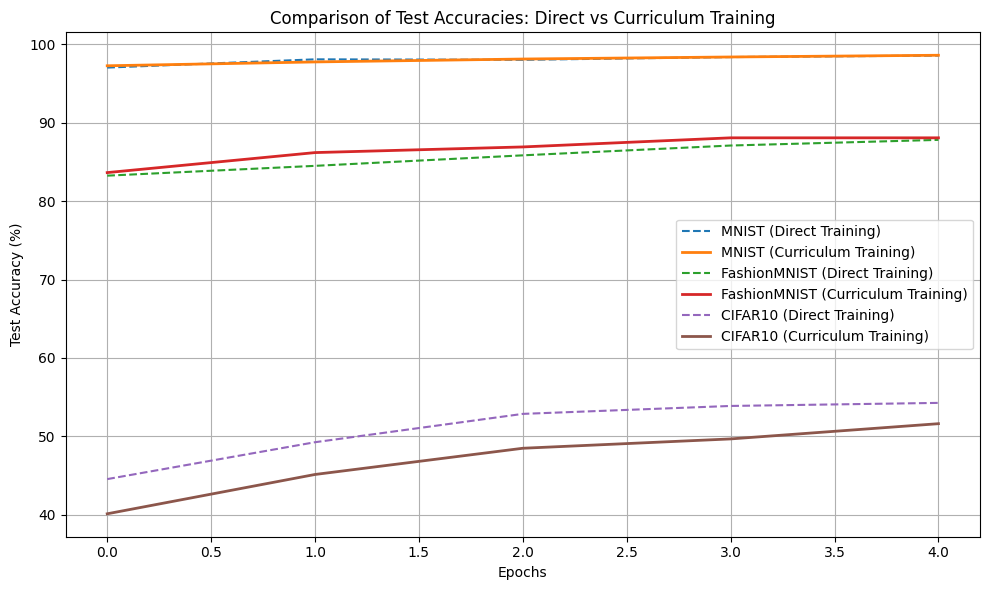

In [17]:
print("--- Comparison of Training Approaches on CIFAR10 ---")

if "CIFAR10" in results:
    direct_train_acc, direct_test_acc, direct_train_loss, direct_test_loss, direct_training_time = results["CIFAR10"]
    print("\nDirect Training on CIFAR10:")
    print(f"  Final Testing Accuracy: {direct_test_acc[-1]:.2f}%")
    print(f"  Final Testing Loss: {direct_test_loss[-1]:.4f}")
    print(f"  Total Training Time: {direct_training_time:.2f} seconds")
else:
    print("\nDirect training results for CIFAR10 not found.")


if "CIFAR10" in curriculum_results:
    seq_train_acc, seq_test_acc, seq_train_loss, seq_test_loss, seq_training_time = curriculum_results["CIFAR10"]
    print("\nCurriculum Training (MNIST -> FashionMNIST -> CIFAR10):")
    print(f"  Final Testing Accuracy: {seq_test_acc[-1]:.2f}%")
    print(f"  Final Testing Loss: {seq_test_loss[-1]:.4f}")
    print(f"  Total Training Time: {seq_training_time:.2f} seconds")
else:
    print("\nCurriculum training results for CIFAR10 not found.")
datasets = ['MNIST', 'FashionMNIST', 'CIFAR10']
print("--------------------------------------------------")

plt.figure(figsize=(10, 6))
for name in datasets:
    direct_test = results[name][1]         # test_acc from direct training
    curriculum_test = curriculum_results[name][1]  # test_acc from curriculum training

    plt.plot(direct_test, label=f'{name} (Direct Training)', linestyle='--')
    plt.plot(curriculum_test, label=f'{name} (Curriculum Training)', linewidth=2)

plt.title("Comparison of Test Accuracies: Direct vs Curriculum Training")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()